# Бэклог

1. Учитывать пропуски когда у нас есть категориальные признаки, так как команда np.isfinite не может работать с типом данных типа стринг



10. Иногда почему то типы float не определяются и остатются обджектами
11. Иногда "NULL" остатются  как str

# Импорт

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle
import os
import seaborn as sns
import datetime
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from itertools import product
# from src import compute_metrics
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

from IPython import display    
import zipfile
import os
import sys
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')



# Загрузка данных

In [2]:
sys.path.insert(1, '../')
import tsad

with open('../../а_печи/data/interim/all_raw_data_single_df.pickle', 'rb') as f:
    data_init = pickle.load(f)

# Преобразования

In [78]:
data = data_init[:100000].copy()
data['categ'] = 'some'
data['bool'] = True
ts = data['bool'].copy()
ts[:]=False
data = pd.concat([data,data['bool']],1)
data = pd.concat([data,data.iloc[-1:,:]],0)


data.iloc[:,3] = np.nan
data.iloc[:,1] = np.nan

data.iloc[55,:] = np.inf

In [79]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100001 entries, 2021-09-01 00:00:00 to 2021-09-02 03:46:39
Columns: 110 entries, 1__AB.05.01_FT01 ||| AB0501_FIT01(текущая) ValueY to bool
dtypes: float64(104), object(6)
memory usage: 84.7+ MB


# наны

In [80]:
mask_nan = data.isin([np.inf, -np.inf, np.nan])

# Полные строки и стобцы

full_nan_col_names = mask_nan.all(0)[mask_nan.all(0)].index.to_list()
full_nan_col_numbers = len(full_nan_col_names)
full_nan_col_percent = round(len(full_nan_col_names)/mask_nan.shape[1] *100,3)


full_nan_row_names = mask_nan.all(1)[mask_nan.all(1)].index.to_list()
full_nan_row_numbers = len(full_nan_row_names)
full_nan_row_percent = round(len(full_nan_row_names)/mask_nan.shape[0] *100,3)

# Еденичные строки

total_nan_number = mask_nan.sum().sum()
total_nan_percent =  round(mask_nan.sum().sum() / mask_nan.size *100,3)

matrix_nan = mask_nan.astype(int).T @ mask_nan.astype(int)

sum_nan_by_col = mask_nan.sum(1)

nan_by_col = pd.Series(np.diag(matrix_nan),index=mask_nan.columns)
nan_by_col.name = 'amount'
if 'index' in nan_by_col.index:
    raise('index col exists, please rename this column')
else:
    nan_by_col['index'] = mask_nan.index.isin([np.inf, -np.inf, np.nan]).sum()
nan_by_col = nan_by_col.to_frame()
nan_by_col['percent%']= (nan_by_col/len(mask_nan)*100).round(3)

In [81]:
nan_dict = {}
nan_dict['full_nan_col_names']= full_nan_col_names
nan_dict['full_nan_col_numbers']= full_nan_col_numbers
nan_dict['full_nan_col_percent']= full_nan_col_percent
nan_dict['full_nan_row_names']= full_nan_row_names
nan_dict['full_nan_row_numbers']= full_nan_row_numbers
nan_dict['full_nan_row_percent']= full_nan_row_percent
nan_dict['total_nan_number']= total_nan_number
nan_dict['total_nan_percent']= total_nan_percent
nan_dict['matrix_nan']= matrix_nan
nan_dict['sum_nan_by_col']= sum_nan_by_col
nan_dict['nan_by_col']= nan_by_col

In [82]:
nan_dict['full_nan_row_names']

[Timestamp('2021-09-01 00:00:55')]

# Дубликаты

In [233]:
full_dupl_row_names

[Timestamp('2021-09-02 03:46:39')]

In [235]:
## Полные строки
mask_row  = data.duplicated()
row_heatmup = mask_row.astype(int)
full_dupl_row_names = mask_row[mask_row].index.to_list()
full_dupl_row_numbers = len(full_dupl_row_names)
full_dupl_row_percent = round(len(full_dupl_row_names)/len(data) *100,3)
## Имена колокнок
dupl_of_column_names = data.columns[data.columns.duplicated()].to_list()
## Дублированные колонки
matrix_dupl_columns_by_values= pd.DataFrame()
for col1 in data:
    for col2 in data:
        if data[col1].equals(data[col2]):
            matrix_dupl_columns_by_values.loc[col1,col2]=1
        else:
            matrix_dupl_columns_by_values.loc[col1,col2]=0        
full_dupl_col_names = {}
for col in matrix_dupl_columns_by_values:
    ts = matrix_dupl_columns_by_values[col].drop(col)
    ts = ts[ts>0]
    if len(ts)>0:
        full_dupl_col_names[col] = ts.index.to_list()
# Список дулированных групп колонок
full_dupl_col_groups = []
for key in full_dupl_col_names:
    my_set = sorted(full_dupl_col_names[key] + [key])
    if my_set in full_dupl_col_groups:
        continue
    else:
        full_dupl_col_groups.append(my_set)
# навзание колонок для удаления
dupl_drop_columns = [item for sublist in full_dupl_col_groups for item in sublist[1:]] 
full_dupl_col_numbers = len(dupl_drop_columns)
full_dupl_col_percent = round(len(dupl_drop_columns)/len(data) *100,3)
## Создание маски
mask_dupl = pd.DataFrame(False,index=data.index,columns=data.columns)
mask_dupl[mask_row] = True
mask_dupl.loc[:,dupl_drop_columns] = True

In [204]:
dupl_of_column_names

['bool']

In [230]:
mask_dupl

,1__AB.05.01_FT01 ||| AB0501_FIT01(текущая) ValueY,1__AB.05.01_FT01 ||| AB0501_FIT01(заданная) ValueY,1__AB.05.01_FT01 ||| AB0501_FIT01(%задания) ValueY,1__AB0501_PT01 ||| AB0501_PT01 ValueY,1__BN.01.01LT ||| Тренд 1 ValueY,1__BW02.01.UC01 ||| PV_Out ValueY,1__CB.01.01.TE05 ||| TE05 Температура под решеткой ValueY,1__CB.01.01.TE06 ||| TE06 Температура газа на выходе из печи ValueY,1__CB.01.01.TE06 ||| TE06 SP задание ValueY,1__CB.01.01.TE06 ||| TE06 MV % исп.мех-м ValueY,...,3__HX.01.03_TT03 ||| ТТ03 MV % на исп. мех-м ValueY,3__HX01.03.TT04 ||| PV_Out ValueY,3__PP.03.03.FT01 ||| FT01 ValueY,3__TV01.03.GI01 ||| мбар ValueY,3__TV01.03.GI01 ||| положение% ValueY,3__WB.01.03_TT01 ||| WB01_TT01 ValueY,3__СВ01.03.ТЕ.05 ||| PV_Out ValueY,categ,bool,bool
time,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-01 00:00:01,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-01 00:00:02,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-01 00:00:03,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-01 00:00:04,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-02 03:46:36,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-02 03:46:37,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021-09-02 03:46:38,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Частота дискретиазции

In [87]:
# проверки
assert len(data)>1
assert isinstance(data.index[0],pd.Timestamp) # слабая проверка лучше через data.dtype.index
assert (data.index == data.sort_index().index).all()
# базовый анализ
index = data.index.to_series()
index_freq_climed = index.index.freq
index_min = index.index[0]
index_max = index.index[-1]
index_duration = index_max - index_min
### считаем разницу между сэмлами
diff = index.diff()
frequence_of_diff = diff.value_counts()
most_frequent_diff_value = frequence_of_diff.index[0]
most_frequent_diff_amount_cases =  frequence_of_diff.iloc[0]
most_frequent_diff_amount_cases_percent = round(most_frequent_diff_amount_cases/len(index) *100,3)
amount_unique_diff = len(frequence_of_diff)
min_diff = frequence_of_diff.sort_index().index[0]
max_diff = frequence_of_diff.sort_index().index[-1]

from tsad.eda.samplingRate import value_counts_interval
intervals=[pd.Timedelta('1s'),
           pd.Timedelta('1m'),
           pd.Timedelta('1h'),
           pd.Timedelta('8h'),
           pd.Timedelta('1D'),
           pd.Timedelta('7D'),
           pd.Timedelta('30D'),
          ]
frequence_of_diff_interval =   value_counts_interval(diff,intervals)

## Обработка

In [ ]:
def process_sampling_rate(df:pd.DataFrame, most_freq, thereshold):
    """
    Обработка 
    """
df2dfs

# Аномалии

## Разработка алгоритма

<AxesSubplot:xlabel='time'>

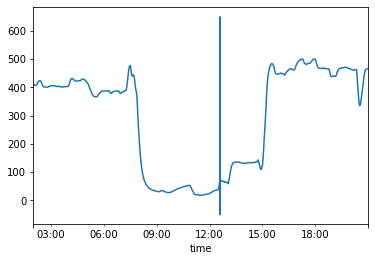

In [95]:
data_processed = data_init[:100000].dropna(0,how='all').dropna(1,how='all').dropna()

ts = data_init['1__CB.01.01.TE05 ||| TE05 Температура под решеткой ValueY']
ts['2021-09-17 02':'2021-09-17 20'].plot()

In [96]:
# from pyod.models.loda import LODA
# from pyod.models.ecod import ECOD
# my_algorithm = LODA()
# # my_algorithm = ECOD()
# my_algorithm.fit(ts.to_frame())
# my = my_algorithm.predict(ts['2021-09-17 02':'2021-09-17 20'].to_frame())
# my = pd.Series(my,
#           index=ts['2021-09-17 02':'2021-09-17 20'].index)
# micro_ts = ts['2021-09-17 02':'2021-09-17 20']
# micro_ts[my==0].plot()
# micro_ts[my==1].plot(marker='o',linewidth=0)

In [97]:
def dummy_outlier_detection(ts:pd.Series, window=100, koef=1.2):
    """
    Примитивный обнаружитель выбросов, основан на анализе разниц значений diff
    ts - численный признак
    window - ширина окна, чем шире, тем менее чувствителен
    koef - коэффициент, чем больше, тем менее чувствителен
    """
    diff_ts = ts.diff()
    ucl = diff_ts.rolling(window).mean().max() * koef
    target = (diff_ts.abs().rolling(window).mean() > ucl).astype(int)
    target = ( (target.shift(-1*window).fillna(0) + target) >= 1).astype(int)
    return target
    
    

In [98]:
pred = dummy_outlier_detection(ts)

<AxesSubplot:xlabel='time'>

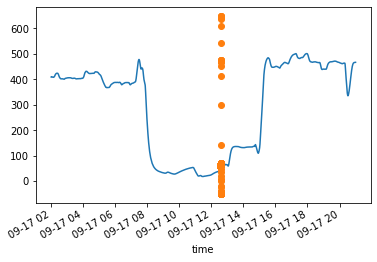

In [99]:
ts[pred==0]['2021-09-17 02':'2021-09-17 20'].plot()
ts[pred==1]['2021-09-17 02':'2021-09-17 20'].plot(marker='o',linewidth=0)

## Имплементация оценки проблемы

In [245]:
# data = data_init[:100000].copy()
## Делаем маску
mask_outlier = pd.DataFrame(False,index=data.index,columns= data.columns)
for col in data.select_dtypes(exclude=object):
    mask_outlier[col] = dummy_outlier_detection(data[col]).astype(bool)
total_outlier_number = mask_outlier.sum().sum()
total_outlier_percent =  round(mask_outlier.sum().sum() / mask_outlier.size *100,3)
# Сотавляем матрицу пересечений и выписываем характеристики
matrix_outlier = mask_outlier.astype(int).T @ mask_outlier.astype(int)
sum_outlier_by_col = mask_outlier.sum(1)
outlier_by_col = pd.Series(np.diag(matrix_outlier),index=mask_outlier.columns)
outlier_by_col = outlier_by_col.to_frame()
outlier_by_col['percent%']= (outlier_by_col/len(mask_outlier)*100).round(3)
# Считаем количество групповых аномалий
from tsad.useful.ts import split_by_repeated
cp_outlier_number_by_col = []
for col in mask_outlier:
    sbr = split_by_repeated(mask_outlier[col])
    if True in sbr:
        cp_outlier_number_by_col.append(len(split_by_repeated(mask_outlier[col])[True]))
    else:
        cp_outlier_number_by_col.append(0)
outlier_by_col['cp numbers'] = cp_outlier_number_by_col
total_cp_outlier_number = outlier_by_col['cp numbers'].sum()

# Очистка данных

In [193]:
common_mask = mask_outlier + mask_dupl + mask_nan
assert common_mask.isna().sum().sum()==0

drop_columns = common_mask.all()[common_mask.all()].index
drop_raw = common_mask.all(1)[common_mask.all(1)].index
drop_cell_number = common_mask.sum().sum()
drop_cell_percent =  round(common_mask.sum().sum() / data.size *100,3)


common_mask[common_mask==True] = np.nan
common_mask[common_mask==False] = 1
new_data = data * common_mask
new_data = new_data.dropna(axis=1,how='all')

new_data = new_data.dropna()

new_data_size = new_data.size
lost_information =  round((data.size -new_data_size  )  / data.size *100,3)

### Дубрирование

In [242]:
# new_columns = []
columns =  np.array(data.columns.to_list())
new_columns =np.array(data.columns.to_list())
for col in dupl_of_column_names:
    amount_of = columns[columns==col]
    new_names = [col] + [f'{col}[duplicated_colname_№{i+1}]' for i in range(len(amount_of)-1)]
    new_columns[new_columns==col] = new_names
        

In [243]:
data.columns = new_columns